## Adding Polarization Updates

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.constants import c,pi,mu_0,epsilon_0
from Luis_Functions import FourierThis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
freq = c/1.0e-6
w = 2*pi*freq

L_T = 80e-6
N_l = 50

wavelength = c/freq
dz1 = wavelength/N_l
N_T = round(L_T/dz1)
dz = L_T/N_T

z = np.arange(0,dz*(N_T+1),dz)

print("Frequency = ", round(freq*1e-12,2), "THz")
print("Wavelength = ", wavelength*1e6, "um")
print("N_T = ", N_T)
print("d_z = ", round(dz*1e9,2), "nm")

Frequency =  299.79 THz
Wavelength =  1.0 um
N_T =  4000
d_z =  20.0 nm


In [85]:
#Gaussian pulse parameters
def EfromI(I):
    E = 2*I/(epsilon_0*c)
    return np.sqrt(E)

bw = 50e12; #Aprox
tau = 1/bw;
A = EfromI(5e12)
def pulse(t,w,tau): 
    t0 = 3*tau;
    return A*np.sin(w*t)*np.exp(-((t-t0)/tau)**2)

In [86]:
S = 0.5
dt = S*dz/c
dt = min([S*dz/c, tau/20])
print("dt = ", dt*1e18, "as")

#Number of time steps
Total_Time = 0.8e-12;
STEPS = round(Total_Time/dt)
print("STEPS = ", STEPS)

dt =  33.3564095198152 as
STEPS =  23983


<IPython.core.display.Javascript object>


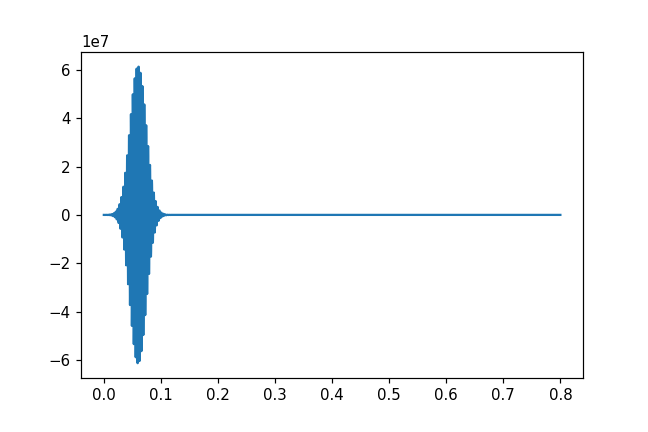

Source Energy =  47.21614273629602


In [87]:
t = np.arange(0,STEPS*dt,dt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t*1e12,pulse(t,w,tau))

#Total energy:
Energy_source = np.sum(pulse(t,w,tau)**2)*dt
print("Source Energy = ", Energy_source)

<IPython.core.display.Javascript object>


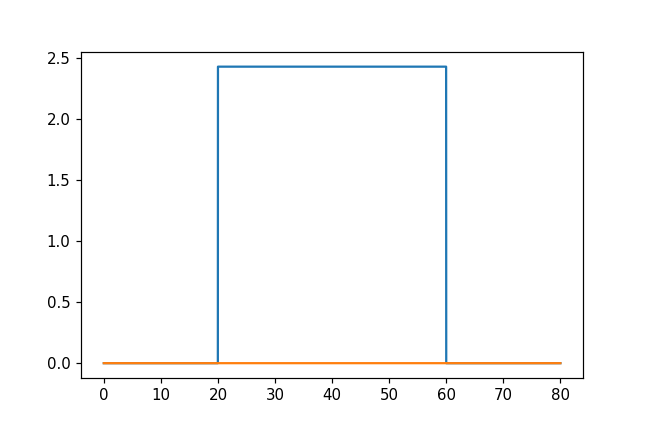

In [88]:
#Simple material model
chi_1_1 = np.zeros(N_T+1)
chi_1_2 = np.zeros(N_T+1)
chi_1_3 = np.zeros(N_T+1)
chi_2_1 = np.zeros(N_T+1)

x1 = 20e-6
x2 = 60e-6
x1_k = round(x1/dz)
x2_k = round(x2/dz)

#Lithium Niobate values
chi_1_1[x1_k:x2_k] = 2.4272
chi_2_1[x1_k:x2_k] = 30e-12
chi_1_2[x1_k:x2_k] = 1.4617
chi_1_3[x1_k:x2_k] = 9.6536

w1 = 1.5494e16
w2 = 7.9514e15
w3 = 9.7766e13

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(z*1e6,chi_1_1,z*1e6,chi_2_1)

In [89]:
#Location of source    
z_source = 1e-6
k_source = round(z_source/dz)
print("k_source = ", k_source)

#location of probe
#k_probe = N_T-100
k_probe = round(65e-6/dz)
print("k_probe = ", k_probe)

#Let's also sample the field at several locations inside the material
kd1 = round((x1+1e-6)/dz)
kd2 = round((x2-1e-6)/dz)
kd_step = round(1e-6/dz)

k_probe_detail = np.arange(kd1, kd2, kd_step)
N_details = k_probe_detail.size
print("# details = ", N_details)

print(k_probe_detail*dz*1e6)

k_source =  50
k_probe =  3250
# details =  38
[21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56.
 57. 58.]


<IPython.core.display.Javascript object>


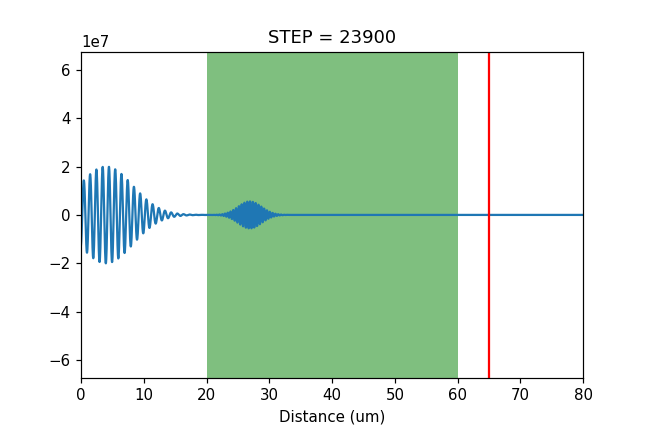

In [90]:
#Initialize fields
ey = np.zeros(N_T+1)
hx = np.zeros(N_T)
jp = np.zeros(N_T+1)

p1 = np.zeros(N_T+1)
jp1 = np.zeros(N_T+1)

p2 = np.zeros(N_T+1)
jp2 = np.zeros(N_T+1)

p3 = np.zeros(N_T+1)
jp3 = np.zeros(N_T+1)

ey_probe = np.zeros(STEPS)
ey_probe_detail = np.zeros((STEPS, N_details))

#Initialize boundary conditions
ey_0_2 = 0
ey_0_1 = 0
ey_N_2 = 0
ey_N_1 = 0

#Initialize dynamic figure
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

#Initialize dynamic figure 2
#fig2 = plt.figure()
#ax2 = fig2.add_subplot(111)
#fig2.canvas.draw()
#ax2.axes.set_xlabel("Distance (um)")
#ax2.margins(0)

#Update factors
alpha_h = dt/(dz*mu_0)
alpha_e = dt/(dz*epsilon_0)
alpha_e2 = dt/(epsilon_0)
alpha_j1 = dt*w1**2
alpha_j2 = dt*w2**2
alpha_j3 = dt*w3**2

for n in range(0,STEPS):

    hx = hx +  alpha_h*(ey[1:]-ey[:N_T])
    ey[1:N_T] = ey[1:N_T] + alpha_e*(hx[1:] - hx[:N_T-1]) - alpha_e2*jp[1:N_T]
    
    jp1[1:N_T] = jp1[1:N_T] + alpha_j1*(epsilon_0*chi_1_1[1:N_T]*ey[1:N_T] + epsilon_0*chi_2_1[1:N_T]*ey[1:N_T]**2 - p1[1:N_T])
    p1[1:N_T] = p1[1:N_T] + dt*jp1[1:N_T]
    
    jp2[1:N_T] = jp2[1:N_T] + alpha_j2*(epsilon_0*chi_1_2[1:N_T]*ey[1:N_T] - p2[1:N_T])
    p2[1:N_T] = p2[1:N_T] + dt*jp2[1:N_T]
    
    jp3[1:N_T] = jp3[1:N_T] + alpha_j3*(epsilon_0*chi_1_3[1:N_T]*ey[1:N_T]- p3[1:N_T])
    p3[1:N_T] = p3[1:N_T] + dt*jp3[1:N_T]
    
    jp = jp1+jp2+jp3

    #Apply source
    ey[k_source] = ey[k_source] + pulse(n*dt,w,tau)
    
    #Apply old boundary condition
    ey[0] = ey_0_2
    ey[N_T] = ey_N_2
    
    #Save boundary condition
    ey_0_2 = ey_0_1
    ey_0_1 = ey[1]
    ey_N_2 = ey_N_1
    ey_N_1 = ey[N_T-1]
    
    #Save field at probe location
    ey_probe[n] = ey[k_probe]
    
    ey_probe_detail[n,:] = ey[k_probe_detail]
    
    if n%100==0:
        ax.clear()
        ax.plot(z*1e6,ey)
        ax.axes.set_ylim(-1.1*A,1.1*A)
        ax.axvspan(x1*1e6, x2*1e6, facecolor='g', alpha=0.5)
        ax.axvline(k_probe*dz*1e6, color='r')
        ax.axes.set_xlabel("Distance (um)")
        ax.margins(0)
        ax.set_title('STEP = %i' % n)
        fig.canvas.draw()
        time.sleep(0.001)
        
        #ax2.clear()
        #ax2.plot(z*1e6,p1)
        #ax.axes.set_ylim(-0.02,0.02)
        #ax2.axvspan(x1*1e6, x2*1e6, facecolor='g', alpha=0.5)  
        #fig2.canvas.draw()
        #time.sleep(0.001)
    
#plt.plot(ey_probe)

<IPython.core.display.Javascript object>


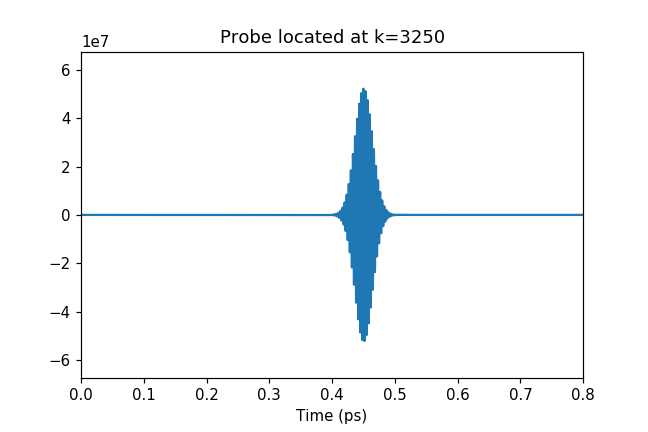

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.plot(t*1e12,ey_probe)
ax.axes.set_ylim(-1.1*A,1.1*A)
ax.axes.set_xlabel('Time (ps)')
ax.margins(0)
ax.set_title('Probe located at k=%i' % k_probe)
fig.canvas.draw()

<IPython.core.display.Javascript object>


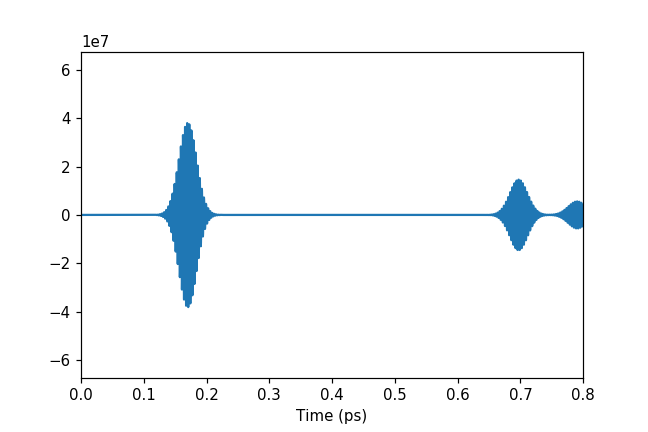

<IPython.core.display.Javascript object>


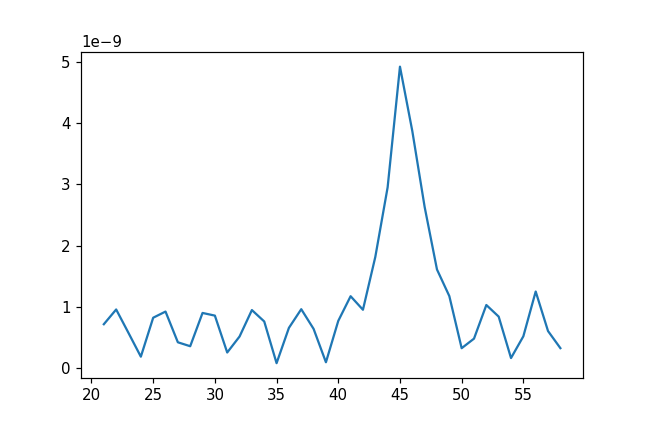

In [92]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.plot(t*1e12,ey_probe_detail[:,5])
ax.axes.set_ylim(-1.1*A,1.1*A)
ax.axes.set_xlabel('Time (ps)')
ax.margins(0)
fig.canvas.draw()

NFFT = 2**14

X_2f0 = np.zeros(N_details)

fig = plt.figure()
ax = fig.add_subplot(111)
for kk in range(N_details):
    X1, freqs1 = FourierThis(ey_probe_detail[:,kk],dt,NFFT,N=1)
    X1 = np.abs(X1)*dt

    #ax.plot(freqs1*1e-12, X1)
    #fig.canvas.draw()
    
    X_2f0[kk] = X1[330]

ax.plot(k_probe_detail*dz*1e6,X_2f0)
#print(X_2f0)

<IPython.core.display.Javascript object>


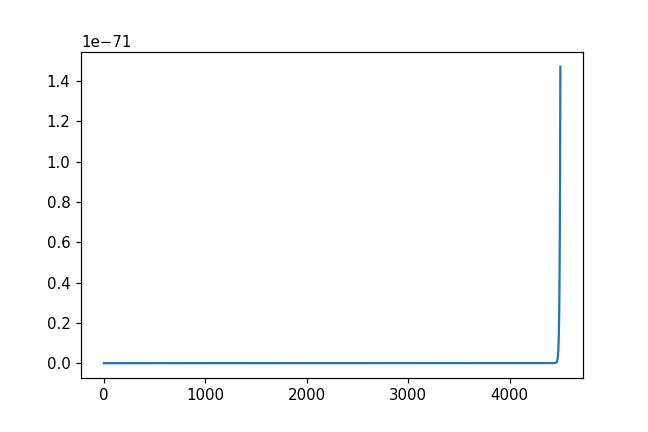

<IPython.core.display.Javascript object>


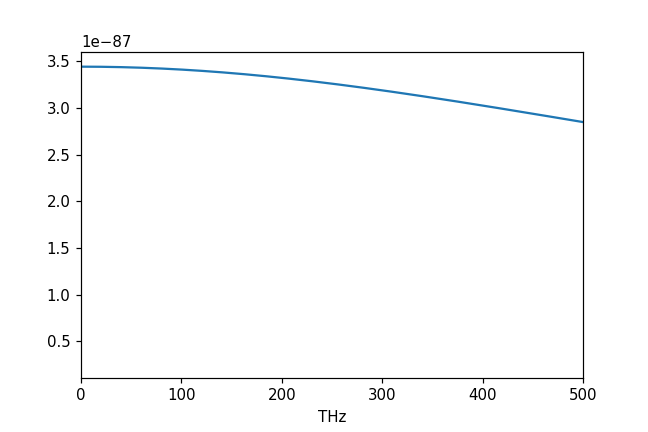

Text(0.5,15,'THz')

In [93]:
x = ey_probe[5000:9500]
#x = ey_probe

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()
ax.plot(x)

NFFT = 2**14
X1, freqs1 = FourierThis(x,dt,NFFT,N=1)
#X2, freqs2 = FourierThis(x,dt,NFFT,N=2)
#X4, freqs4 = FourierThis(x,dt,NFFT,N=4)

X1 = np.abs(X1)*dt

fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()

ax.plot(freqs1*1e-12, X1)
#ax.plot(freqs2*1e-12, np.abs(X2))
#ax.plot(freqs4*1e-12, np.abs(X4))

ax.set_xlim(0,500)
ax.set_xlabel('THz')

# Energy relations:

In [16]:
xt = x
Xf = X1
energy_t = np.sum(xt**2)*dt
N = len(xt)
Nf = 2*len(Xf)
energy_f = (Xf[0]**2 + 2*np.sum(Xf[1:]**2))/(dt*Nf)

print("Nt = ", N)
print("Nf = ", Nf)
print("E_t = ", energy_t)
print("E_f = ", energy_f)

print("Delta from source = ", Energy_source - energy_t)

Nt =  1999
Nf =  16386
E_t =  0.3220336304586146
E_f =  0.3219943695602898
Delta from source =  1253313.8141141764


<IPython.core.display.Javascript object>


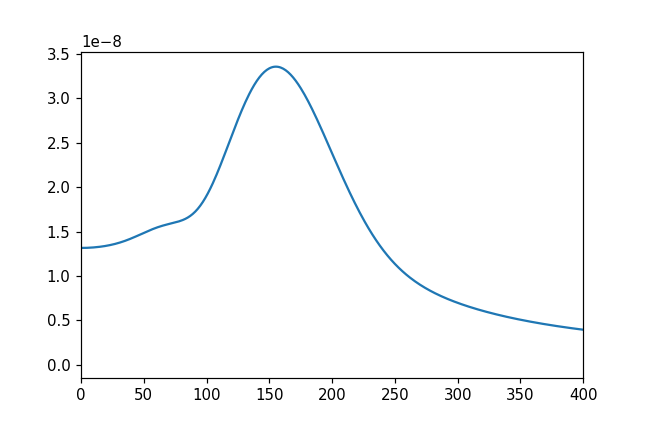

E_dc =  0.00021149086588058292
E_f0 =  0.23790929868059824
E_2f0 =  0.010640317215146192
E_total =  0.248761106761625


In [17]:
#Isolate bands
fig = plt.figure()
ax = fig.add_subplot(111)
fig.canvas.draw()

ax.plot(Xf)
ax.set_xlim(0,400)

Xf_dc = Xf[0]
Xf_f0 = Xf[100:240]
Xf_2f0 = Xf[270:380]

#ax.plot(Xf_f0)
#ax.set_xlim(0:400)

#Also DC
energy_dc = Xf_dc**2/(dt*Nf)
print("E_dc = ", energy_dc)

#Fundamental
energy_f0 = 2*np.sum(Xf_f0**2)/(dt*Nf)
print("E_f0 = ", energy_f0)

#Second harmonic
energy_2f0 = 2*np.sum(Xf_2f0**2)/(dt*Nf)
print("E_2f0 = ", energy_2f0)

#Total check
E_total = energy_dc + energy_f0 + energy_2f0
print("E_total = ", E_total)